In [1]:
import itertools
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load MoveNet Thunder model
from script.data import BodyPart

In [3]:
def load_pose_landmarks(csv_path):
  # Load the CSV file
  dataframe = pd.read_csv(csv_path)

  # Drop the file_name columns as you don't need it during training.
  dataframe.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = dataframe.pop('class_name').unique()

  # Extract the labels
  y = dataframe.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = dataframe.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes

In [4]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER, BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new, [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0, name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform substraction
  pose_center = tf.broadcast_to(pose_center, [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [4]:
class ClassifierModel(object):
    def __init__(self, class_names):
        self.model = None
        self.class_names = class_names

    def build_model(self, model_path=None):
        if model_path:
            self.model = keras.models.load_model(model_path)
        else:
            inputs = keras.Input(shape=(51))
            embedding = landmarks_to_embedding(inputs)

            layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
            layer = keras.layers.Dropout(0.5)(layer)
            layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
            layer = keras.layers.Dropout(0.5)(layer)
            outputs = keras.layers.Dense(len(self.class_names), activation="softmax")(layer)

            model = keras.Model(inputs, outputs)
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            self.model = model

    def train(self, X_data, y_data, test_size=0.15, monitor="val_accuracy", patience=20, batch_size=16, epochs=200,
              cp_path="best.weight.hdf5", save_path=None):
        # Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
        X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=test_size)
        # Add a checkpoint callback to store the checkpoint that has the highest
        # validation accuracy.
        checkpoint = keras.callbacks.ModelCheckpoint(cp_path, monitor=monitor, verbose=1, save_best_only=True, mode='max')
        early_stopping = keras.callbacks.EarlyStopping(monitor=monitor, patience=patience)

        # Start training
        his = self.model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs,
                                 callbacks=[checkpoint, early_stopping], validation_data=(X_val, y_val))

        if save_path:
            self.model.save(save_path)

        return his

    def evaluate(self, X, y):
        l, acc = self.model.evaluate(X, y)

        return l, acc

    def predict(self, X):
        pred = self.model.predict(X)
        return pred

    def save_tflite(self, save_path):
        converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        model = converter.convert()

        with open(f'{save_path}/pose_classifier.tflite', 'wb') as f:
          f.write(model)
        print('Model size: %dKB' % (len(model) / 1024))

In [5]:
csvs_out_train_path = './data/train_data.csv'
csvs_out_test_path = './data/test_data.csv'

# Load the train data
X, y, class_names = load_pose_landmarks(csvs_out_train_path)
# Load the test data
X_test, y_test, _ = load_pose_landmarks(csvs_out_test_path)

In [6]:
classifier = ClassifierModel(class_names)
# classifier.build_model()
classifier.build_model("./model/classifier")

In [8]:
# Start training
history = classifier.train(X, y, cp_path="./model/weights.best.hdf5", save_path="./model/classifier/")

Epoch 1/200
 1/37 [..............................] - ETA: 29s - loss: 1.6135 - accuracy: 0.0625
Epoch 1: val_accuracy improved from -inf to 0.54902, saving model to ./model\weights.best.hdf5
37/37 [==============================] - 1s 9ms/step - loss: 1.5144 - accuracy: 0.4377 - val_loss: 1.3581 - val_accuracy: 0.5490
Epoch 2/200
32/37 [========================>.....] - ETA: 0s - loss: 1.2521 - accuracy: 0.5391
Epoch 2: val_accuracy improved from 0.54902 to 0.61765, saving model to ./model\weights.best.hdf5
37/37 [==============================] - 0s 3ms/step - loss: 1.2318 - accuracy: 0.5433 - val_loss: 1.0390 - val_accuracy: 0.6176
Epoch 3/200
26/37 [====================>.........] - ETA: 0s - loss: 1.0460 - accuracy: 0.5697
Epoch 3: val_accuracy improved from 0.61765 to 0.74510, saving model to ./model\weights.best.hdf5
37/37 [==============================] - 0s 3ms/step - loss: 1.0269 - accuracy: 0.5796 - val_loss: 0.8502 - val_accuracy: 0.7451
Epoch 4/200
27/37 [=================

INFO:tensorflow:Assets written to: ./model/classifier.pb\assets


INFO:tensorflow:Assets written to: ./model/classifier.pb\assets


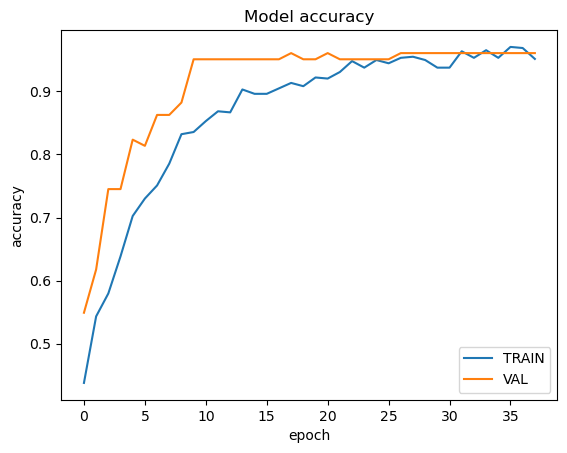

In [9]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [7]:
# Evaluate the model using the TEST dataset
loss, accuracy = classifier.evaluate(X_test, y_test)

14/14 [==============================] - 0s 2ms/step - loss: 0.0535 - accuracy: 0.9953


14/14 [==============================] - 0s 2ms/step
Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

       chair       1.00      1.00      1.00        84
       cobra       0.98      1.00      0.99        93
         dog       1.00      1.00      1.00        84
        tree       1.00      1.00      1.00        96
     warrior       1.00      0.97      0.99        68

    accuracy                           1.00       425
   macro avg       1.00      0.99      0.99       425
weighted avg       1.00      1.00      1.00       425



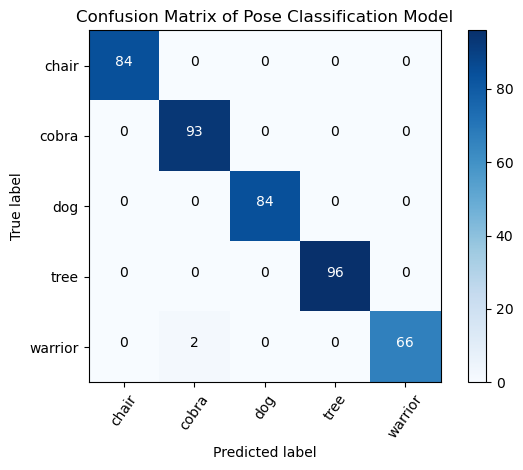

In [8]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = classifier.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm, class_names, title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label, y_pred_label))

In [11]:
classifier.save_tflite("./model/")

INFO:tensorflow:Assets written to: C:\Users\17214\AppData\Local\Temp\tmpyad9a44k\assets


INFO:tensorflow:Assets written to: C:\Users\17214\AppData\Local\Temp\tmpyad9a44k\assets


Model size: 26KB
